In [1]:
%matplotlib inline

### Tutorial overview
This tutorial provides a demo of how to use Cue to discover variants given a small BAM file provided here: ```data/demo/inputs/chr21.small.bam```.
This file contains alignments to a region of ```GRCh38``` ```chr21``` of short reads from a synthetic genome.

The ground-truth variants simulated in this region of the genome are provided here:
```data/demo/ground_truth/svs.chr21.small.vcf.gz```.

The associated YAML config files needed to execute this workflow are provided in the ```data/demo/config``` directory.

### Initial setup

Copy the demo configuration files into the desired results folder. Cue generally writes the results of each command into the parent folder of the provided config file(s).


In [8]:
%%sh
mkdir ../data/demo/results
cp ../data/demo/config/data.yaml ../data/demo/results/.
cp ../data/demo/config/model.yaml ../data/demo/results/.

mkdir: ../data/demo/results: File exists


The YAML configuration files contain input parameter settings needed to execute Cue. To perform variant calling, Cue takes a data-specific config file (```data.yaml```) and a model-specific config file (```model.yaml```), which specify parameters used to process the input BAM file and execute the pretrained deep learning model, respectively.

Two parameters are required in the data YAML file: (1) the path to the input BAM file and (2) the reference file index; for example:
```
bam: "data/demo/inputs/chr21.small.bam"
fai: "data/demo/inputs/GRCh38.fa.fai"
```

One parameter is required in the model YAML file -- the path to the pretrained model:

```
model_path: "data/models/cue.pt"
```
Several additional parameters can be optionally controlled by the user (as described in the documentation), while the remaining parameters should be left untouched.

### Structural variant calling

The following command will call variants given the sample input BAM file and the provided pretrained Cue model (in ```data/models```) on a single CPU.
This command will launch Cue in variant discovery mode. The input BAM file will first be indexed and then the genome will be scanned to generate images
and make predictions. This process should take about 5-6 minutes in total on one CPU. This command can be executed on the GPU by providing
the desired GPU id in the ```gpu_ids``` field of the ```model.yaml``` file. For example, to run on GPU 0, set this field as follows:
```gpu_ids: [0]```. Multiple GPU ids can be provided to parallelize SV calling across multiple devices when running on a full-genome dataset.


In [9]:
%%sh
export PYTHONPATH=${PYTHONPATH}:..
source ../env/bin/activate

python ../engine/call.py --data_config ../data/demo/results/data.yaml --model_config ../data/demo/results/model.yaml

[INFO]  ===== Config =====
	YAML config file: ../data/demo/results/model.yaml
	Experiment directory: /Users/vpopic/research/cue/data/demo/results
	Device: cpu
	Main LOG file: /Users/vpopic/research/cue/data/demo/results/logs/main.log
	model_path: ../data/models/cue.pt
	gpu_ids: []
	report_interval: 5
	pretrained_refinenn_path: None
	image_dim: 256
	class_set: SV_CLASS_SET.BASIC5ZYG
	signal_set: SV_SIGNAL_SET.SHORT
	num_keypoints: 1
	model_architecture: HG
	batch_size: 16
	sigma: 10
	stride: 4
	heatmap_peak_threshold: 0.65
	config_file: ../data/demo/results/model.yaml
	experiment_dir: /Users/vpopic/research/cue/data/demo/results
	devices: [device(type='cpu')]
	device: cpu
	tb_dir: /Users/vpopic/research/cue/data/demo/results/tb/
	log_dir: /Users/vpopic/research/cue/data/demo/results/logs/
	report_dir: /Users/vpopic/research/cue/data/demo/results/reports/
	log_file: /Users/vpopic/research/cue/data/demo/results/logs/main.log
	classes: ['NEG', 'DEL-HOM', 'INV-HOM', 'DUP-HOM', 'DEL-HET', 'I

The output of the program will be generated in the ```data/demo/results``` directory.
In particular, the discovered SVs will be provided here: ```data/demo/results/reports/svs.vcf ``` (Cue outputs both a BED and a VCF file with results).

For example, here are three SVs discovered by the model ranked by confidence score (given in ```QUAL``` column).

```
#CHROM  POS     ID      REF     ALT     QUAL    FILTER  INFO    FORMAT  SAMPLE
chr21   10399416        DUP     N       <DUP>   86      PASS    END=10427813;SVTYPE=DUP;SVLEN=28398     GT      0/1
chr21   14855666        INV     N       <INV>   82      PASS    END=14870587;SVTYPE=INV;SVLEN=14922     GT      0/1
chr21   14874025        DEL     N       <DEL>   82      PASS    END=14891603;SVTYPE=DEL;SVLEN=17579     GT      1/1
```

Intermediate model predictions in image space are stored under the ```data/demo/results/reports/predictions/``` directory for ```chr21```, along with images depicting the keypoint predictions (these are reported for result visualization only at specified batch intervals).

In [11]:
%%sh
cat ../data/demo/results/reports/svs.vcf | grep -v "##" | head -n 4

#CHROM	POS	ID	REF	ALT	QUAL	FILTER	INFO	FORMAT	SAMPLE
chr21	10399416	DUP	N	<DUP>	86	PASS	END=10427813;SVTYPE=DUP;SVLEN=28398	GT	0/1
chr21	14855666	INV	N	<INV>	82	PASS	END=14870587;SVTYPE=INV;SVLEN=14922	GT	0/1
chr21	14874025	DEL	N	<DEL>	82	PASS	END=14891603;SVTYPE=DEL;SVLEN=17579	GT	1/1


### Structural variant callset evaluation (Optional)

We can evaluate the calls against the ground truth SVs using Truvari.
In order to execute Truvari, we need to post-process the produced VCF to the input format required by Truvari;
in particular, we need to sort, compress, and index the SV VCF file. We recommend using ```bcftools``` and ```htslib```
for this task as follows.

In [12]:
%%sh
# a. Sort the VCF by position
bcftools sort ../data/demo/results/reports/svs.vcf > ../data/demo/results/reports/svs.sorted.vcf

# b. Compress the sorted VCF
bgzip -f ../data/demo/results/reports/svs.sorted.vcf

# c. Index the compressed VCF
bcftools index -t ../data/demo/results/reports/svs.sorted.vcf.gz

Writing to /tmp/bcftools-sort.dBiTD7
Merging 1 temporary files
Cleaning
Done


In [17]:
%%sh
source ../env/bin/activate

# install Truvari
python -m pip install Truvari

# We can now execute Truvari as follows:
truvari bench -b ../data/demo/ground_truth/svs.chr21.small.sorted.vcf.gz -c ../data/demo/results/reports/svs.sorted.vcf.gz -o ../data/demo/results/reports/truvari --pctsize=0.5 --pctov=0.5 --passonly --sizemax 5000000 --pctsim 0 --gtcomp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 KB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.1/64.1 KB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.0/307.0 KB 7.3 MB/s eta 0:00:00
  Using cached pandas-1.3.5-cp37-cp37m-macosx_10_9_x86_64.whl (11.0 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 KB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-macosx_11_0_x86_64.whl size=81192 sha256=99cd69e2c83ecb32221ec09c1b279dcd110dbc39b003b69b53e576b2a3a9866a
  Stored in directory: /Users/vpopic/Library/Caches/pip/wheels/05/5f/ca/7c4367734892581bb5ff896f15027a932c551080b2abd3e00d
Successfully built python-Levenshtein
  Attempting uninstall: python-Levenshtein
    Found existing installat

You should consider upgrading via the '/Users/vpopic/research/cue/env/bin/python -m pip install --upgrade pip' command.
2022-05-24 15:49:37,774 [INFO] Running /Users/vpopic/research/cue/env/bin/truvari bench -b ../data/demo/ground_truth/svs.chr21.small.sorted.vcf.gz -c ../data/demo/results/reports/svs.sorted.vcf.gz -o ../data/demo/results/reports/truvari --pctsize=0.5 --pctov=0.5 --passonly --sizemax 5000000 --pctsim 0 --gtcomp
2022-05-24 15:49:37,774 [INFO] Params:
{
    "base": "../data/demo/ground_truth/svs.chr21.small.sorted.vcf.gz",
    "comp": "../data/demo/results/reports/svs.sorted.vcf.gz",
    "output": "../data/demo/results/reports/truvari",
    "reference": null,
    "giabreport": false,
    "debug": false,
    "prog": false,
    "refdist": 500,
    "pctsim": 0.0,
    "minhaplen": 50,
    "pctsize": 0.5,
    "pctovl": 0.5,
    "typeignore": false,
    "use_lev": false,
    "chunksize": 1000,
    "gtcomp": true,
    "bSample": null,
    "cSample": null,
    "sizemin": 50,
   

Truvari will report the precision, recall, and F1 score for this small benchmark. The above command will require a genotype match to consider an SV call a true positive (TP).

In [19]:
%%sh
# To view the full Truvari summary:
cat ../data/demo/results/reports/truvari/summary.txt

{
    "TP-base": 16,
    "TP-call": 16,
    "FP": 0,
    "FN": 1,
    "precision": 1.0,
    "recall": 0.9411764705882353,
    "f1": 0.9696969696969697,
    "base cnt": 17,
    "call cnt": 16,
    "TP-call_TP-gt": 16,
    "TP-call_FP-gt": 0,
    "TP-base_TP-gt": 16,
    "TP-base_FP-gt": 0,
    "gt_concordance": 1.0,
    "gt_matrix": {
        "(0, 1)": {
            "(0, 1)": 10
        },
        "(1, 1)": {
            "(1, 1)": 6
        }
    }
}

We can see that Cue discovered 16 out of the 17 events simulated in this region with an exact genotype match and no false positives.
Additional information produced by Truvari can be found here: ```data/demo/results/reports/truvari```.

### Visualizing the SVs results

To visually evaluate the results, we can generate annotated Cue images and separate image channels centered around each discovered SV
using the provided ```engine/view.py``` script. These channels can be used to evaluate various alignment signals contributing to each SV call.


In [26]:
%%sh
source ../env/bin/activate

cp ../data/demo/config/view.yaml ../data/demo/results/.
python ../engine/view.py --config ../data/demo/results/view.yaml

[INFO] ==== Dataset ====
bam: ../data/demo/inputs/chr21.small.bam
	fai: ../data/demo/inputs/GRCh38.fa.fai
	bed: ../data/demo/results/reports/svs.vcf
	n_cpus: 1
	chr_names: ['chr21']
	blacklist_bed: None
	bam_type: BAM_TYPE.SHORT
	signal_set: SV_SIGNAL_SET.SHORT
	signal_set_origin: SHORT
	signal_vmax: {'RD': 600, 'RD_LOW': 800, 'RD_CLIPPED': 600, 'SM': 200, 'SR_RP': 600, 'LR': 600, 'LLRR': 100, 'RL': 100, 'LLRR_VS_LR': 1}
	signal_mapq: {'RD': 20, 'RD_LOW': 0, 'RD_CLIPPED': 20, 'SM': 20, 'SR_RP': 0, 'LR': 0, 'LLRR': 1, 'RL': 1, 'LLRR_VS_LR': 1}
	bin_size: 750
	interval_size: [150000]
	step_size: [50000]
	shift_size: [0, 70000, 140000]
	heatmap_dim: 1000
	image_dim: 256
	class_set: SV_CLASS_SET.BASIC5ZYG
	num_keypoints: 1
	bbox_padding: 0
	config_file: ../data/demo/results/view.yaml
	dataset_dir: /Users/vpopic/research/cue/data/demo/results
	info_dir: /Users/vpopic/research/cue/data/demo/results/info/
	image_dir: /Users/vpopic/research/cue/data/demo/results/images/
	annotation_dir: /Users

The annotations and channels for the above three events can be generated as follows (note that other events may appear in the same image if they are nearby).

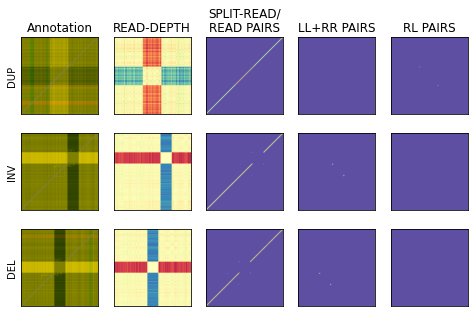

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def plot_images(imgs, row_labels, col_labels):
    n_rows, n_cols = len(imgs), len(imgs[0])
    fig = plt.figure(figsize=(8,5))
    fig.tight_layout()
    for i in range(n_rows):
        for j in range(n_cols):
            ax = plt.subplot(n_rows, n_cols, i*n_cols + j + 1)
            if not i:
                ax.title.set_text(col_labels[j])
            if not j:
                ax.set_ylabel(row_labels[i])
            plt.xticks([])
            plt.yticks([])
            img = imgs[i][j]
            plt.imshow(img, cmap="Spectral_r")
        
# set up the generated image paths
ann_img_prefix = "../data/demo/results/annotated_images/0000000000"
ch_img_prefix = "../data/demo/results/images/0000000000"
img_fnames = {"DUP": "chr21_10349415-10477813_&_chr21_10349415-10477813.png",
              "INV": "chr21_14805665-14920587_&_chr21_14805665-14920587.png",
              "DEL": "chr21_14824024-14941603_&_chr21_14824024-14941603.png"}

# load the annotated images for each event
images = [[np.array(Image.open("%s_0_%s" % (ann_img_prefix, img_fnames["DUP"])), copy=False)],
          [np.array(Image.open("%s_1_%s" % (ann_img_prefix, img_fnames["INV"])), copy=False)],
          [np.array(Image.open("%s_2_%s" % (ann_img_prefix, img_fnames["DEL"])), copy=False)]]

# load the image channels for each event
for channel in range(1, 5):
    for i,sv in enumerate(img_fnames.keys()):
        images[i].append(np.array(Image.open("%s_%s.ch%d.png" % (ch_img_prefix, img_fnames[sv], channel)), copy=False))

image_labels = ["Annotation", "READ-DEPTH", "SPLIT-READ/\nREAD PAIRS", "LL+RR PAIRS", "RL PAIRS"]
plot_images(images, list(img_fnames.keys()), image_labels)
